In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.sparse.linalg as spla

np.set_printoptions(linewidth=130)

In [2]:
from fsmfuncs import *
from ibmfuncs import *
from gridfuncs import *

Numerical grid for the fluid

In [3]:
s1 = stretching(256, 0.033, 0.20, int(0.65/0.033), 16, 16, 0.04)[0]
s2 = stretching(128, 0.033, 0.20, int(0.65/0.033), 16, 16, 0.04)[0]
x = np.concatenate([-s2[::-1], s1[1:]])
s = stretching(192, 0.033, 0.20, int(0.65/0.033), 16, 16, 0.04)[0]
y = np.concatenate([-s[::-1], s[1:]])

n, m = len(y)-1, len(x)-1

dy, dx = np.diff(y), np.diff(x)
dxmin = min(np.min(dx), np.min(dy))

yp, xp = 0.5*(y[1:] + y[:-1]), 0.5*(x[1:] + x[:-1])
dyp, dxp = np.diff(yp), np.diff(xp)
p = np.zeros( (n, m) )

yu, xu = yp, x[1:-1]
u = np.zeros( (n, m-1) )

yv, xv = y[1:-1], xp
v = np.zeros( (n-1, m) )

Immersed boundary

In [4]:
r_ = 0.5
l = int((2*np.pi*r_)/dxmin)
ang_ = 2*np.pi*np.arange(l)/l
xi = 0 + r_*np.cos(ang_)
eta = 0 + r_*np.sin(ang_)
ds = 2*np.pi*r_/l*np.ones(l)
uB = np.zeros_like(xi)
vB = np.zeros_like(xi)

Plot grid and immersed boundary

(-2, 2)

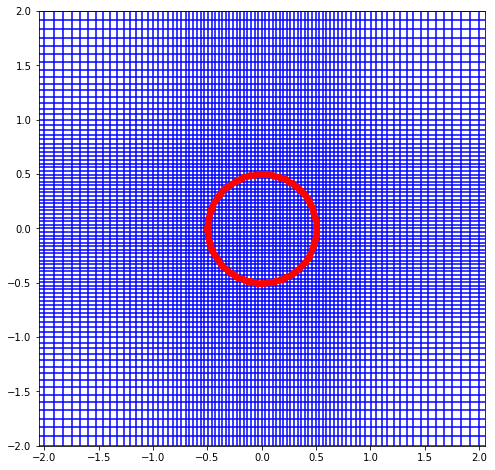

In [5]:
plt.figure(figsize=(8,8))
X, Y = np.meshgrid(x, y)
plt.plot(X, Y, 'b-')
plt.plot(X.T, Y.T, 'b-')
plt.plot(xi, eta, 'ro-')
plt.axis('equal');
plt.xlim(-2, 2)
plt.ylim(-2, 2)

In [6]:
uS, uN = np.ones(m-1), np.ones(m-1)
uE, uW = np.ones(n), np.ones(n)

vS, vN = np.zeros(m), np.zeros(m)
vE, vW = np.zeros(n-1), np.zeros(n-1)

u[:,:]=1
v[:,:]=0

Build matrices (I)

In [7]:
G, DuW, DuE, DvS, DvN = gradient(dxp, dyp)
R, iR = weight (dx, dy)
Mh, iMh = mass_hat (dxp, dyp)
Lh, Lux0, Lux1, Luy0, Luy1, Lvx0, Lvx1, Lvy0, Lvy1 = laplacian_hat(dx, dy, dxp, dyp)
Eh = interpolation_hat(xi, eta, ds, xu, yu, xv, yv, dx, dy, dxp, dyp)
Hh = regularization_hat(xi, eta, ds, xu, yu, xv, yv, dx, dy, dxp, dyp)

E = Eh.dot(iR)
H = Mh.dot(Hh)

L = Mh.dot(Lh.dot(iR))

M = Mh.dot(iR)
iM = R.dot(iMh)

EET = E.dot(E.T)
EH = E.dot(H).tocsc()
iEH = spla.factorized(EH)

iML = iM.dot(L)
Q = sp.hstack([G, E.T])

Build matrices (II)

In [8]:
iRe = 1/200.0
dt = 0.40 * min(dxmin**2/iRe, dxmin)
print(dt, dxmin**2/iRe, dxmin)

0.0132 0.2178 0.033


In [9]:
A = (M/dt - 0.5*iRe*L).tocsc()
B = (M/dt + 0.5*iRe*L).tocsr()

iA = spla.factorized(A)

BN = dt*iM + (0.5*iRe)*dt**2*iML.dot(iM) + (0.5*iRe)**2*dt**3*iML.dot(iML.dot(iM))
QTBNQ = Q.T.dot(BN.dot(Q)).tocsc()
iQTBNQ = spla.factorized(QTBNQ)

In [10]:
q = R.dot(np.concatenate([u.ravel(), v.ravel()]))
qast = q.copy()

Num1, Nvm1 = advection_hat(dx, dy, dxp, dyp, iR.dot(q),  uS, uN, uW, uE, vS, vN, vW, vE)
Nu, Nv = Num1, Nvm1

In [11]:
nt = int(100/dt)
print("Performing", nt, "steps")

residuals = np.zeros(nt)
CFx = np.zeros(nt)
CFy = np.zeros(nt)

for k in range(nt):    
    ru = iRe*(Lux0.dot(uW) + Lux1.dot(uE) + Luy0.dot(uS) + Luy1.dot(uN)) - 1.5*Nu + 0.5*Num1
    rv = iRe*(Lvx0.dot(vW) + Lvx1.dot(vE) + Lvy0.dot(vS) + Lvy1.dot(vN)) - 1.5*Nv + 0.5*Nvm1
    
    bc1 = Mh.dot(np.concatenate([ru, rv]))
    r1 = B.dot(q.ravel()) + bc1

    qast = iA(r1)
    
    bc2 = - (DuW.dot(uW*dy) + DuE.dot(uE*dy) + DvS.dot(vS*dx) + DvN.dot(vN*dx))
    r2 = np.concatenate([-bc2, uB, vB])

    λ = iQTBNQ(Q.T.dot(qast) - r2)

    qp1 = qast - BN.dot(Q.dot(λ))
    
    residuals[k] = la.norm(qp1-q)/(dt*la.norm(qp1))
    
    f = -iEH(EET.dot(λ[n*m:]))
    CFx[k], CFy[k] = -2*np.sum(f[:l]*ds), -2*np.sum(f[l:]*ds)
 
    if k%10==0:
        print(k, k*dt, residuals[k], CFx[k], CFy[k])
    
    q = qp1
    uE = uE - dt/dx[-1]*(uE - iR.dot(q)[:n*(m-1)].reshape((n, m-1))[:,-1])
    
    Num1, Nvm1 = Nu, Nv
    Nu, Nv = advection_hat(dx, dy, dxp, dyp, iR.dot(q), uS, uN, uW, uE, vS, vN, vW, vE)

Performing 7575 steps
0 0.0 1.55007758339 264.371127211 0.00123450825407
10 0.132 0.0160918651071 1.38236722464 -0.000137113351752
20 0.264 0.0121076403897 1.16254859601 -7.69569430135e-05
30 0.396 0.01116180284 1.11348963316 -4.79717673432e-05
40 0.528 0.0109754897645 1.12755613422 -2.68121830443e-05
50 0.66 0.0110057306781 1.16829313348 -7.3424186271e-06
60 0.792 0.0110708014464 1.2180134616 1.2817805519e-05
70 0.924 0.0111029226688 1.26659644568 3.18087335463e-05
80 1.056 0.0110786155419 1.30818244777 4.74311038884e-05
90 1.188 0.0109934472315 1.33973904211 5.87530724675e-05
100 1.32 0.0108507275108 1.36031970068 6.5880211449e-05
110 1.452 0.0106564188856 1.3704917871 6.95347393017e-05
120 1.584 0.0104169911566 1.37179629837 7.05769336763e-05
130 1.716 0.0101392974578 1.36624373265 6.97928050292e-05
140 1.848 0.00983089399951 1.35589745285 6.78084923375e-05
150 1.98 0.00950007575822 1.34258828781 6.50628402882e-05
160 2.112 0.0091555298845 1.32776878956 6.18065567109e-05
170 2.244 0

1370 18.084 0.00181187207166 0.932433989209 0.00140324687497
1380 18.216 0.00180470936421 0.931823902429 0.00150208405842
1390 18.348 0.00179766712573 0.931220530966 0.00159107622485
1400 18.48 0.00179074330685 0.930623973333 0.00166898156599
1410 18.612 0.00178393641618 0.930034409399 0.00173460942452
1420 18.744 0.00177724558958 0.929452085182 0.00178683326219
1430 18.876 0.00177067061647 0.928877292303 0.00182460350596
1440 19.008 0.00176421194491 0.928310343163 0.00184696015256
1450 19.14 0.00175787070099 0.927751543368 0.00185304501283
1460 19.272 0.00175164875749 0.927201163427 0.00184211348014
1470 19.404 0.00174554886965 0.926659412064 0.00181354570904
1480 19.536 0.00173957486568 0.926126413547 0.0017668570925
1490 19.668 0.00173373184932 0.925602191319 0.00170170792723
1500 19.8 0.00172802635424 0.925086659754 0.00161791215673
1510 19.932 0.00172246639524 0.924579625197 0.0015154450819
1520 20.064 0.00171706138955 0.924080796547 0.0013944499287
1530 20.196 0.00171182196093 0.

2720 35.904 0.0135180960379 0.89991153796 0.0134166461265
2730 36.036 0.0139494772173 0.900234135075 0.0155152140124
2740 36.168 0.0143957346008 0.900586388661 0.0175671335348
2750 36.3 0.0148571531156 0.900969592404 0.0195525949355
2760 36.432 0.0153339595641 0.901385018514 0.0214513440414
2770 36.564 0.015826322361 0.901833917974 0.0232428187397
2780 36.696 0.0163343537094 0.902317523515 0.0249062955756
2790 36.828 0.016858114256 0.902837055534 0.0264210458695
2800 36.96 0.0173976200783 0.903393731157 0.0277665006451
2810 37.092 0.0179528516655 0.903988776638 0.0289224235937
2820 37.224 0.018523764402 0.904623443303 0.0298690913013
2830 37.356 0.0191102999753 0.90529902723 0.0305874800251
2840 37.488 0.0197123981479 0.906016892817 0.031059458437
2850 37.62 0.0203300084367 0.90677850028 0.0312679859401
2860 37.752 0.0209631014198 0.907585436934 0.0311973163871
2870 37.884 0.0216116795782 0.908439451809 0.0308332072737
2880 38.016 0.0222757877056 0.909342492782 0.0301631346969
2890 38.

4140 54.648 0.105877553129 1.17493512013 0.215836235794
4150 54.78 0.105933402062 1.17880317108 0.245840989102
4160 54.912 0.106000852419 1.18335885129 0.270166174063
4170 55.044 0.106080810934 1.18831123507 0.287973883021
4180 55.176 0.106172693356 1.19330657411 0.298600413303
4190 55.308 0.106274797296 1.19796580111 0.301583994472
4200 55.44 0.106384588054 1.20192828971 0.296681161529
4210 55.572 0.106499140066 1.20489603981 0.2838706786
4220 55.704 0.106615342363 1.20667171434 0.263346082624
4230 55.836 0.106730092297 1.20718482661 0.235500025478
4240 55.968 0.106840343418 1.20650261595 0.200904898406
4250 56.1 0.106943247242 1.20482494623 0.160294151413
4260 56.232 0.107036368075 1.20246492504 0.114547281704
4270 56.364 0.107117972925 1.19981826856 0.0646791725487
4280 56.496 0.107187426958 1.19732479867 0.0118321119941
4290 56.628 0.107245378229 1.19542530002 -0.0427329452714
4300 56.76 0.107293902418 1.19451680676 -0.0976500509004
4310 56.892 0.107336255107 1.19490952408 -0.15147

5610 74.052 0.118593131795 1.32713018938 -0.351807183754
5620 74.184 0.118708898253 1.31493852913 -0.260978990429
5630 74.316 0.118833525251 1.30302552293 -0.163126265012
5640 74.448 0.11896660547 1.29261779455 -0.0603710020325
5650 74.58 0.119107119022 1.28485962777 0.0449293281167
5660 74.712 0.119253892464 1.28068687532 0.150167612715
5670 74.844 0.119405821041 1.28069730692 0.252510538885
5680 74.976 0.119561821019 1.28503913906 0.348975159474
5690 75.108 0.119720521975 1.29334686669 0.436566167575
5700 75.24 0.119880138616 1.30475294283 0.512464467545
5710 75.372 0.120038511609 1.31798965377 0.574235779095
5720 75.504 0.120193570481 1.33156861967 0.620012713686
5730 75.636 0.120343979116 1.34399753753 0.648606428647
5740 75.768 0.120489898706 1.35398099868 0.659526022677
5750 75.9 0.120633577092 1.36056266953 0.65291389609
5760 76.032 0.120779655078 1.36319273978 0.629427687138
5770 76.164 0.120934891709 1.36173141902 0.590105970757
5780 76.296 0.121107350047 1.35641342063 0.53624

7080 93.456 0.134578639908 1.34218601273 -0.639978176361
7090 93.588 0.133833347553 1.35422373649 -0.664417734212
7100 93.72 0.133196206084 1.36344823247 -0.670784887915
7110 93.852 0.132660032688 1.36899378816 -0.659407481078
7120 93.984 0.132218449307 1.37042011685 -0.631100759654
7130 94.116 0.131868096366 1.36769776402 -0.587029355184
7140 94.248 0.131610257339 1.36116301377 -0.52859171497
7150 94.38 0.131446780471 1.35146434029 -0.457342049655
7160 94.512 0.131372741206 1.33950908606 -0.374953956023
7170 94.644 0.131372098911 1.32640715655 -0.283221496312
7180 94.776 0.131418928225 1.31340279222 -0.18408769263
7190 94.908 0.13148188701 1.30178626536 -0.0796869464042
7200 95.04 0.131528780862 1.29278230778 0.0276138096495
7210 95.172 0.131530435127 1.28741896191 0.135191872531
7220 95.304 0.131464217733 1.28638905624 0.240181964817
7230 95.436 0.131317331312 1.28992649101 0.339544213
7240 95.568 0.13108840048 1.29772846517 0.430197886607
7250 95.7 0.130786877957 1.3089557598 0.5092

In [13]:
iRq = iR.dot(q)
u, v = iRq[:n*(m-1)].reshape((n, m-1)), iRq[n*(m-1):].reshape((n-1, m))
p = λ[:n*m].reshape((n,m))
f = λ[n*m:]

Display solution

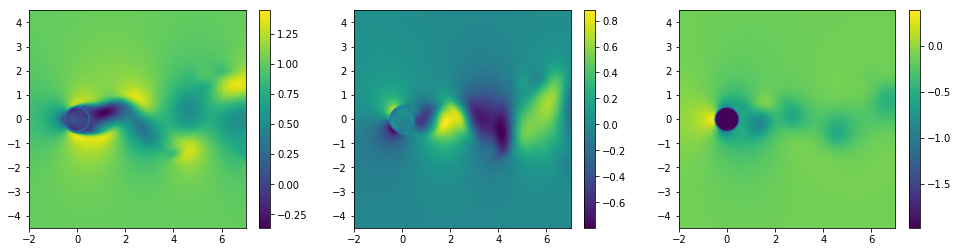

In [14]:
x0, x1 = -2, 7
y0, y1 = -4.5, 4.5
plt.figure(figsize=(5.5*3,4))
plt.subplot(1,3,1)
plt.pcolormesh(xu, yu, u, shading='gouraud')
plt.plot(xi, eta, lw=1)
plt.xlim(x0, x1)
plt.ylim(y0, y1)
plt.colorbar()

plt.subplot(1,3,2)
plt.pcolormesh(xv, yv, v, shading='gouraud')
plt.plot(xi, eta, lw=1)
plt.xlim(x0, x1)
plt.ylim(y0, y1)
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(xp, yp, p, shading='gouraud')
plt.plot(xi, eta, lw=1)
plt.xlim(x0, x1)
plt.ylim(y0, y1)
plt.colorbar()

95


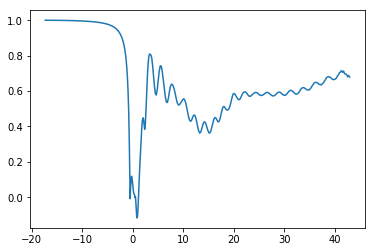

In [15]:
plt.plot(xu, u[n//2,:])
print(l)

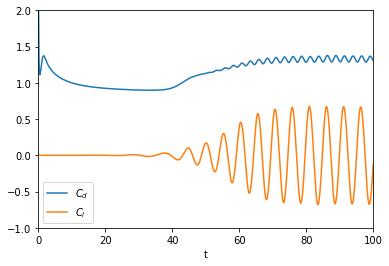

In [17]:
plt.plot(np.arange(len(CFy))*dt, CFx, label=r'$C_d$')
plt.plot(np.arange(len(CFy))*dt, CFy, label=r'$C_l$')

plt.xlim(0, 100)
plt.ylim(-1, 2)
plt.xlabel('t')
plt.legend()